In [87]:
import pandas as pd
import os
import numpy as np
from datetime import datetime

In [88]:
file_list = os.listdir()
file_list = [name for name in file_list if name.startswith("olist")]
file_list

['olist_orders_dataset.csv',
 'olist_customers_dataset.csv',
 'olist_order_items_dataset.csv']

In [89]:
files = {}
for file in file_list:
    files['{}'.format(file).split('.')[0]] = pd.read_csv('{}'.format(file))
olist_orders_dataset = files['olist_orders_dataset'].query("order_purchase_timestamp.notnull()")
olist_customers_dataset = files['olist_customers_dataset']
olist_order_items_dataset = files['olist_order_items_dataset']

In [90]:
one_order_customers = (
    olist_orders_dataset.merge(olist_customers_dataset, how='inner', on='customer_id')
        .groupby('customer_unique_id')
        .agg({'order_id': 'count'})
        .reset_index()
        .query("order_id == 1")['customer_unique_id']
        .nunique()
)
one_order_customers
# first task - 93099
# add filter

93099

In [91]:
not_customer_delivered = olist_orders_dataset[olist_orders_dataset['order_delivered_customer_date'].isna()]

In [92]:
not_customer_delivered['month_purchase'] = pd.to_datetime(not_customer_delivered['order_purchase_timestamp']).dt.to_period('M')
not_customer_delivered

/tmp/ipykernel_15159/708013749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_customer_delivered['month_purchase'] = pd.to_datetime(not_customer_delivered['order_purchase_timestamp']).dt.to_period('M')


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_purchase
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,2017-04
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00,2018-08
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00,2017-09
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00,2018-01
...,...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,2018-08
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00,2018-01
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,2018-09
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00,2017-08


In [93]:
month_not_delivered = (
    not_customer_delivered.groupby(['month_purchase', 'order_status'])
                            .agg({'order_id': 'count'})
                            .query("order_status != 'delivered'")
                            .reset_index()
                            .groupby('order_status')
                            .agg({'order_id': 'sum'})
                            .reset_index()
)

month_not_delivered['total_months'] = not_customer_delivered['month_purchase'].nunique()
month_not_delivered['fails_per_month'] = month_not_delivered.order_id / month_not_delivered.total_months
month_not_delivered
# second task answer

,order_status,order_id,total_months,fails_per_month
0,approved,2,24,0.083333
1,canceled,619,24,25.791667
2,created,5,24,0.208333
3,invoiced,314,24,13.083333
4,processing,301,24,12.541667
5,shipped,1107,24,46.125000
6,unavailable,609,24,25.375000


In [94]:
month_not_delivered.groupby('order_status').agg({'order_id': 'mean'}).round(0)
# created - order was created by a customer but it was not approved by the company
# approved - the order was approved by the company but an invoice was not created or there was some kind of a problem with it
# invoiced - an invoce was went to the customer but was not paid
# processing - when the order was paid for in an invoice but the order could not be collected
# shipped - the order was shipped by the company but never delivered by the shipping service
# cancelled - the order was cancelled a client
# unavailable - not sure???
# the short answer - during the whole process of order creation and delivery there appeared problems specific to that link in the process

,order_id
order_status,
approved,2.0
canceled,619.0
created,5.0
invoiced,314.0
processing,301.0
shipped,1107.0
unavailable,609.0


In [95]:
order_items = olist_order_items_dataset.merge(olist_orders_dataset, on='order_id')
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25 00:00:00


In [96]:
order_items['order_purchase_timestamp'] = pd.to_datetime(order_items['order_purchase_timestamp'])
order_items['DOW'] = order_items['order_purchase_timestamp'].dt.day_name()
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,DOW
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,Saturday


In [97]:
orders_per_items = order_items.groupby(['product_id', 'DOW']).agg({'order_id': 'count'}).reset_index()
orders_per_items

,product_id,DOW,order_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61225,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61226,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
61227,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [98]:
top_weekday_per_item = orders_per_items.groupby(['product_id']).head(1).reset_index(drop=True)
top_weekday_per_item
# third task

,product_id,DOW,order_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday,1
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
32948,fff9553ac224cec9d15d49f5a263411f,Friday,1
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1


In [99]:
customer_orders = olist_customers_dataset.merge(olist_orders_dataset, how='left', on='customer_id')
customer_orders.sort_values(['customer_unique_id', 'order_approved_at'])

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
64012,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21 00:00:00
24570,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15 00:00:00
40832,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07 00:00:00
57118,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,41272756ecddd9a9ed0180413cc22fb6,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13 00:00:00
81150,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,d957021f1127559cd947b62533f484f7,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
89147,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,55250,sanharo,PE,725cf8e9c24e679a8a5a32cb92c9ce1e,delivered,2017-06-08 21:00:36,2017-06-08 21:15:16,2017-06-23 13:03:27,2017-07-06 09:22:00,2017-08-02 00:00:00
9810,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,44054,feira de santana,BA,c71b9252fd7b3b263aaa4cb09319a323,delivered,2017-12-10 20:07:56,2017-12-10 20:16:20,2017-12-21 16:27:01,2018-01-09 22:28:20,2018-01-12 00:00:00
69017,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,78552,sinop,MT,fdc45e6c7555e6cb3cc0daca2557dbe1,delivered,2017-02-07 15:49:16,2017-02-07 16:02:44,2017-02-08 10:04:37,2017-02-22 12:45:04,2017-03-24 00:00:00
94891,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,29460,bom jesus do norte,ES,94d3ee0bc2a0af9d4fa47a4d63616e8d,delivered,2018-05-02 15:17:41,2018-05-02 15:58:47,2018-05-03 16:45:00,2018-05-14 11:54:26,2018-05-28 00:00:00


In [100]:
customer_orders['order_approved_at'] = pd.to_datetime(customer_orders['order_approved_at'])
customer_orders['order_purchase_timestamp'] = pd.to_datetime(customer_orders['order_purchase_timestamp'])
customer_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [101]:
first_last_order = customer_orders.groupby('customer_unique_id') \
    .agg({'order_approved_at': 'max',
        'order_purchase_timestamp': 'min',
        'order_id': 'count'}) \
    .reset_index().sort_values('order_id')
first_last_order['weeks_active'] = ((first_last_order.order_approved_at - first_last_order.order_purchase_timestamp).dt.days)/7
first_last_order['orders_per_week'] = first_last_order['order_id']/first_last_order['weeks_active']
first_last_order
# fourth task

,customer_unique_id,order_approved_at,order_purchase_timestamp,order_id,weeks_active,orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,2018-05-10 10:56:27,1,0.000000,inf
63580,a926cfc9bc7b082335de50450f48eec9,2018-04-24 20:55:46,2018-04-24 20:40:44,1,0.000000,inf
63579,a926aae38267e7f54e67de9b5775d0a5,2018-08-02 13:04:36,2018-08-02 12:05:23,1,0.000000,inf
63578,a92605ec492805540520d3a73aaeeb6e,2017-12-15 17:44:01,2017-12-15 16:55:06,1,0.000000,inf
63577,a925c3e5df82fdc6082f1383d2834998,2018-04-17 06:11:32,2018-04-15 16:50:27,1,0.142857,7.000000
...,...,...,...,...,...,...
76082,ca77025e7201e3b30c44b472ff346268,2018-06-02 03:31:41,2017-10-09 12:34:39,7,33.571429,0.208511
37797,6469f99c1f9dfae7733b25662e7f1782,2018-06-28 01:11:21,2017-09-19 01:02:44,7,40.285714,0.173759
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,2018-02-15 04:11:01,2017-11-13 16:44:41,7,13.285714,0.526882
23472,3e43e6105506432c953e165fb2acf44c,2018-02-27 18:50:29,2017-09-18 18:53:15,9,23.000000,0.391304


In [102]:
month_cohort = customer_orders.groupby('customer_unique_id') \
    .agg({'order_purchase_timestamp': 'min'}) \
    .reset_index() \
    .rename(columns={'order_purchase_timestamp': 'cohort_time'}) \
    .sort_values('cohort_time', ascending=False)
month_cohort

,customer_unique_id,cohort_time
50975,87ab9fec999db8bd5774917de3cdf01c,2018-10-17 17:30:18
58524,9bb92bebd4cb7511e1a02d5e50bc4655,2018-09-29 09:13:03
72940,c1ee153508c6b785b491443a95ff364e,2018-09-13 09:56:12
3583,09687a7b7431a93b5c53b50ba779bf94,2018-09-11 16:45:54
3955,0a5dadb73145d29f42f703c97c377ae8,2018-09-06 10:48:12
...,...,...
5521,0eb1ee9dba87f5b36b4613a65074337c,2016-10-02 22:07:52
49312,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38
238,009b0127b727ab0ba422f6d9604487c7,2016-09-13 15:24:19
27245,4854e9b3feff728c13ee5fc7d1547e92,2016-09-05 00:15:34


In [103]:
# month_cohort.order_approved_at = pd.to_datetime(month_cohort['order_approved_at'])
month_cohort['month_coh'] = month_cohort.cohort_time.dt.month
month_cohort['month_cohort_year'] = month_cohort.cohort_time.dt.to_period('M')
month_cohort

,customer_unique_id,cohort_time,month_coh,month_cohort_year
50975,87ab9fec999db8bd5774917de3cdf01c,2018-10-17 17:30:18,10,2018-10
58524,9bb92bebd4cb7511e1a02d5e50bc4655,2018-09-29 09:13:03,9,2018-09
72940,c1ee153508c6b785b491443a95ff364e,2018-09-13 09:56:12,9,2018-09
3583,09687a7b7431a93b5c53b50ba779bf94,2018-09-11 16:45:54,9,2018-09
3955,0a5dadb73145d29f42f703c97c377ae8,2018-09-06 10:48:12,9,2018-09
...,...,...,...,...
5521,0eb1ee9dba87f5b36b4613a65074337c,2016-10-02 22:07:52,10,2016-10
49312,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,9,2016-09
238,009b0127b727ab0ba422f6d9604487c7,2016-09-13 15:24:19,9,2016-09
27245,4854e9b3feff728c13ee5fc7d1547e92,2016-09-05 00:15:34,9,2016-09


In [104]:
cohort_orders = month_cohort.merge(customer_orders, how='left', on='customer_unique_id')
cohort_orders['month_after'] = (cohort_orders.order_purchase_timestamp.dt.year - cohort_orders.month_cohort_year.dt.year) * 12 + (cohort_orders.order_purchase_timestamp.dt.month - cohort_orders.month_cohort_year.dt.month)
cohort_orders = cohort_orders.query("month_cohort_year > '2016-12' & month_cohort_year < '2018-01'")
cohort_orders

,customer_unique_id,cohort_time,month_coh,month_cohort_year,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_after
53246,19a589165490fdd58381a271750e959f,2017-12-31 23:29:31,12,2017-12,de4f592a5c6155b2fe6f87b30aaeec9c,99704,erechim,RS,070a76f4c338fe3cda93745a22e51270,delivered,2017-12-31 23:29:31,2018-01-01 23:26:52,2018-01-02 19:28:35,2018-01-10 19:27:29,2018-02-02 00:00:00,0
53247,5d11f19985edbb3c068e805434a80f87,2017-12-31 23:24:10,12,2017-12,dc3daad47c0792f3bd4366246a7955dc,95820,general camara,RS,8acda261d8c76b3206d9cb5279d0a18a,delivered,2017-12-31 23:24:10,2017-12-31 23:32:40,2018-01-04 11:15:57,2018-01-23 22:37:13,2018-02-08 00:00:00,0
53248,b890928f02ba9a0dfbc6ec8009bee0fd,2017-12-31 22:14:53,12,2017-12,92566e623b70efba98063150b200cba4,74290,goiania,GO,18f39cbc016f34a22c870ef03cba5641,delivered,2017-12-31 22:14:53,2017-12-31 22:26:35,2018-01-02 18:35:39,2018-01-22 22:57:47,2018-01-31 00:00:00,0
53249,addd42012ed67639f9e0d26155b7c2e1,2017-12-31 21:17:54,12,2017-12,2f368064b4e6646a7784a46b03b4bcbc,4126,sao paulo,SP,43e38490d21c8c490334f75c5a7c2861,delivered,2017-12-31 21:17:54,2017-12-31 21:27:24,2018-01-02 20:17:58,2018-01-05 17:59:20,2018-02-01 00:00:00,0
53250,e6797b7d4c35624ef13982ab27d3255b,2017-12-31 21:10:02,12,2017-12,98a1a1e41310f70974831b79bf01e4e6,4140,sao paulo,SP,60d98124c3228470422ecadff6550e3c,delivered,2017-12-31 21:10:02,2017-12-31 21:26:47,2018-01-02 15:08:20,2018-01-05 18:51:54,2018-01-18 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99096,728e4a7d0db4845270091ded0923c71f,2017-01-05 12:06:36,1,2017-01,42d857e22f61f10476f0cda1aacc018a,80540,curitiba,PR,6acecf438369055d9243e121045cca74,delivered,2017-01-05 12:11:23,2017-01-07 03:44:07,2017-01-11 16:22:53,2017-01-17 16:06:30,2017-02-13 00:00:00,0
99097,83e7958a94bd7f74a9414d8782f87628,2017-01-05 12:01:20,1,2017-01,ff3c6d35b4927c9b965aa6a68dcf56e4,80030,curitiba,PR,b95a0a8bd30aece4e94e81f0591249d8,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13 00:00:00,0
99098,83e7958a94bd7f74a9414d8782f87628,2017-01-05 12:01:20,1,2017-01,3f402674c608ea67085eb5e0ec4d96ef,80030,curitiba,PR,0bda8164c1a12b6a388ebec8559ee287,delivered,2017-01-05 13:36:07,2017-01-07 03:45:47,2017-01-11 16:09:00,2017-01-16 17:27:34,2017-02-13 00:00:00,0
99099,83e7958a94bd7f74a9414d8782f87628,2017-01-05 12:01:20,1,2017-01,5da810af4515e4470379a90fcf246a15,80030,curitiba,PR,3ce4038922670fead496aeae61a8a393,delivered,2017-01-05 13:52:39,2017-01-07 03:44:23,2017-01-11 15:37:55,2017-01-16 14:04:35,2017-02-13 00:00:00,0


In [105]:
cohorts = (
    cohort_orders.groupby(['month_cohort_year', 'month_after'])
                    .agg({'customer_unique_id': 'nunique'})
                    .reset_index()
                    .pivot(index='month_cohort_year', columns='month_after', values='customer_unique_id')
                    .fillna(0)
)
cohorts = cohorts.divide(cohorts[0], axis=0).round(4)
cohorts
# fifth task 2017-11

month_after,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
month_cohort_year,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.0039,0.0026,0.0013,0.0039,0.0013,0.0052,0.0013,0.0013,0.0000,0.0039,0.0013,0.0079,0.0039,0.0013,0.0013,0.0026,0.0039,0.0013
2017-02,1.0,0.0023,0.0029,0.0011,0.0040,0.0011,0.0023,0.0017,0.0017,0.0023,0.0011,0.0029,0.0017,0.0017,0.0011,0.0006,0.0006,0.0023,0.0000
2017-03,1.0,0.0049,0.0038,0.0038,0.0034,0.0015,0.0015,0.0030,0.0034,0.0008,0.0038,0.0015,0.0023,0.0011,0.0015,0.0023,0.0008,0.0015,0.0000
2017-04,1.0,0.0060,0.0021,0.0017,0.0034,0.0026,0.0034,0.0030,0.0030,0.0017,0.0026,0.0009,0.0009,0.0004,0.0009,0.0009,0.0021,0.0000,0.0000
2017-05,1.0,0.0050,0.0050,0.0039,0.0031,0.0033,0.0042,0.0017,0.0025,0.0031,0.0025,0.0033,0.0025,0.0003,0.0019,0.0025,0.0000,0.0000,0.0000
2017-06,1.0,0.0048,0.0035,0.0041,0.0025,0.0038,0.0038,0.0022,0.0013,0.0022,0.0032,0.0035,0.0016,0.0013,0.0019,0.0000,0.0000,0.0000,0.0000
2017-07,1.0,0.0051,0.0036,0.0026,0.0028,0.0021,0.0031,0.0010,0.0018,0.0026,0.0023,0.0031,0.0013,0.0026,0.0000,0.0000,0.0000,0.0000,0.0000
2017-08,1.0,0.0069,0.0033,0.0026,0.0036,0.0053,0.0029,0.0026,0.0014,0.0014,0.0024,0.0019,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-09,1.0,0.0068,0.0053,0.0029,0.0046,0.0022,0.0022,0.0024,0.0029,0.0017,0.0027,0.0007,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<AxesSubplot: xlabel='month_after', ylabel='month_cohort_year'>

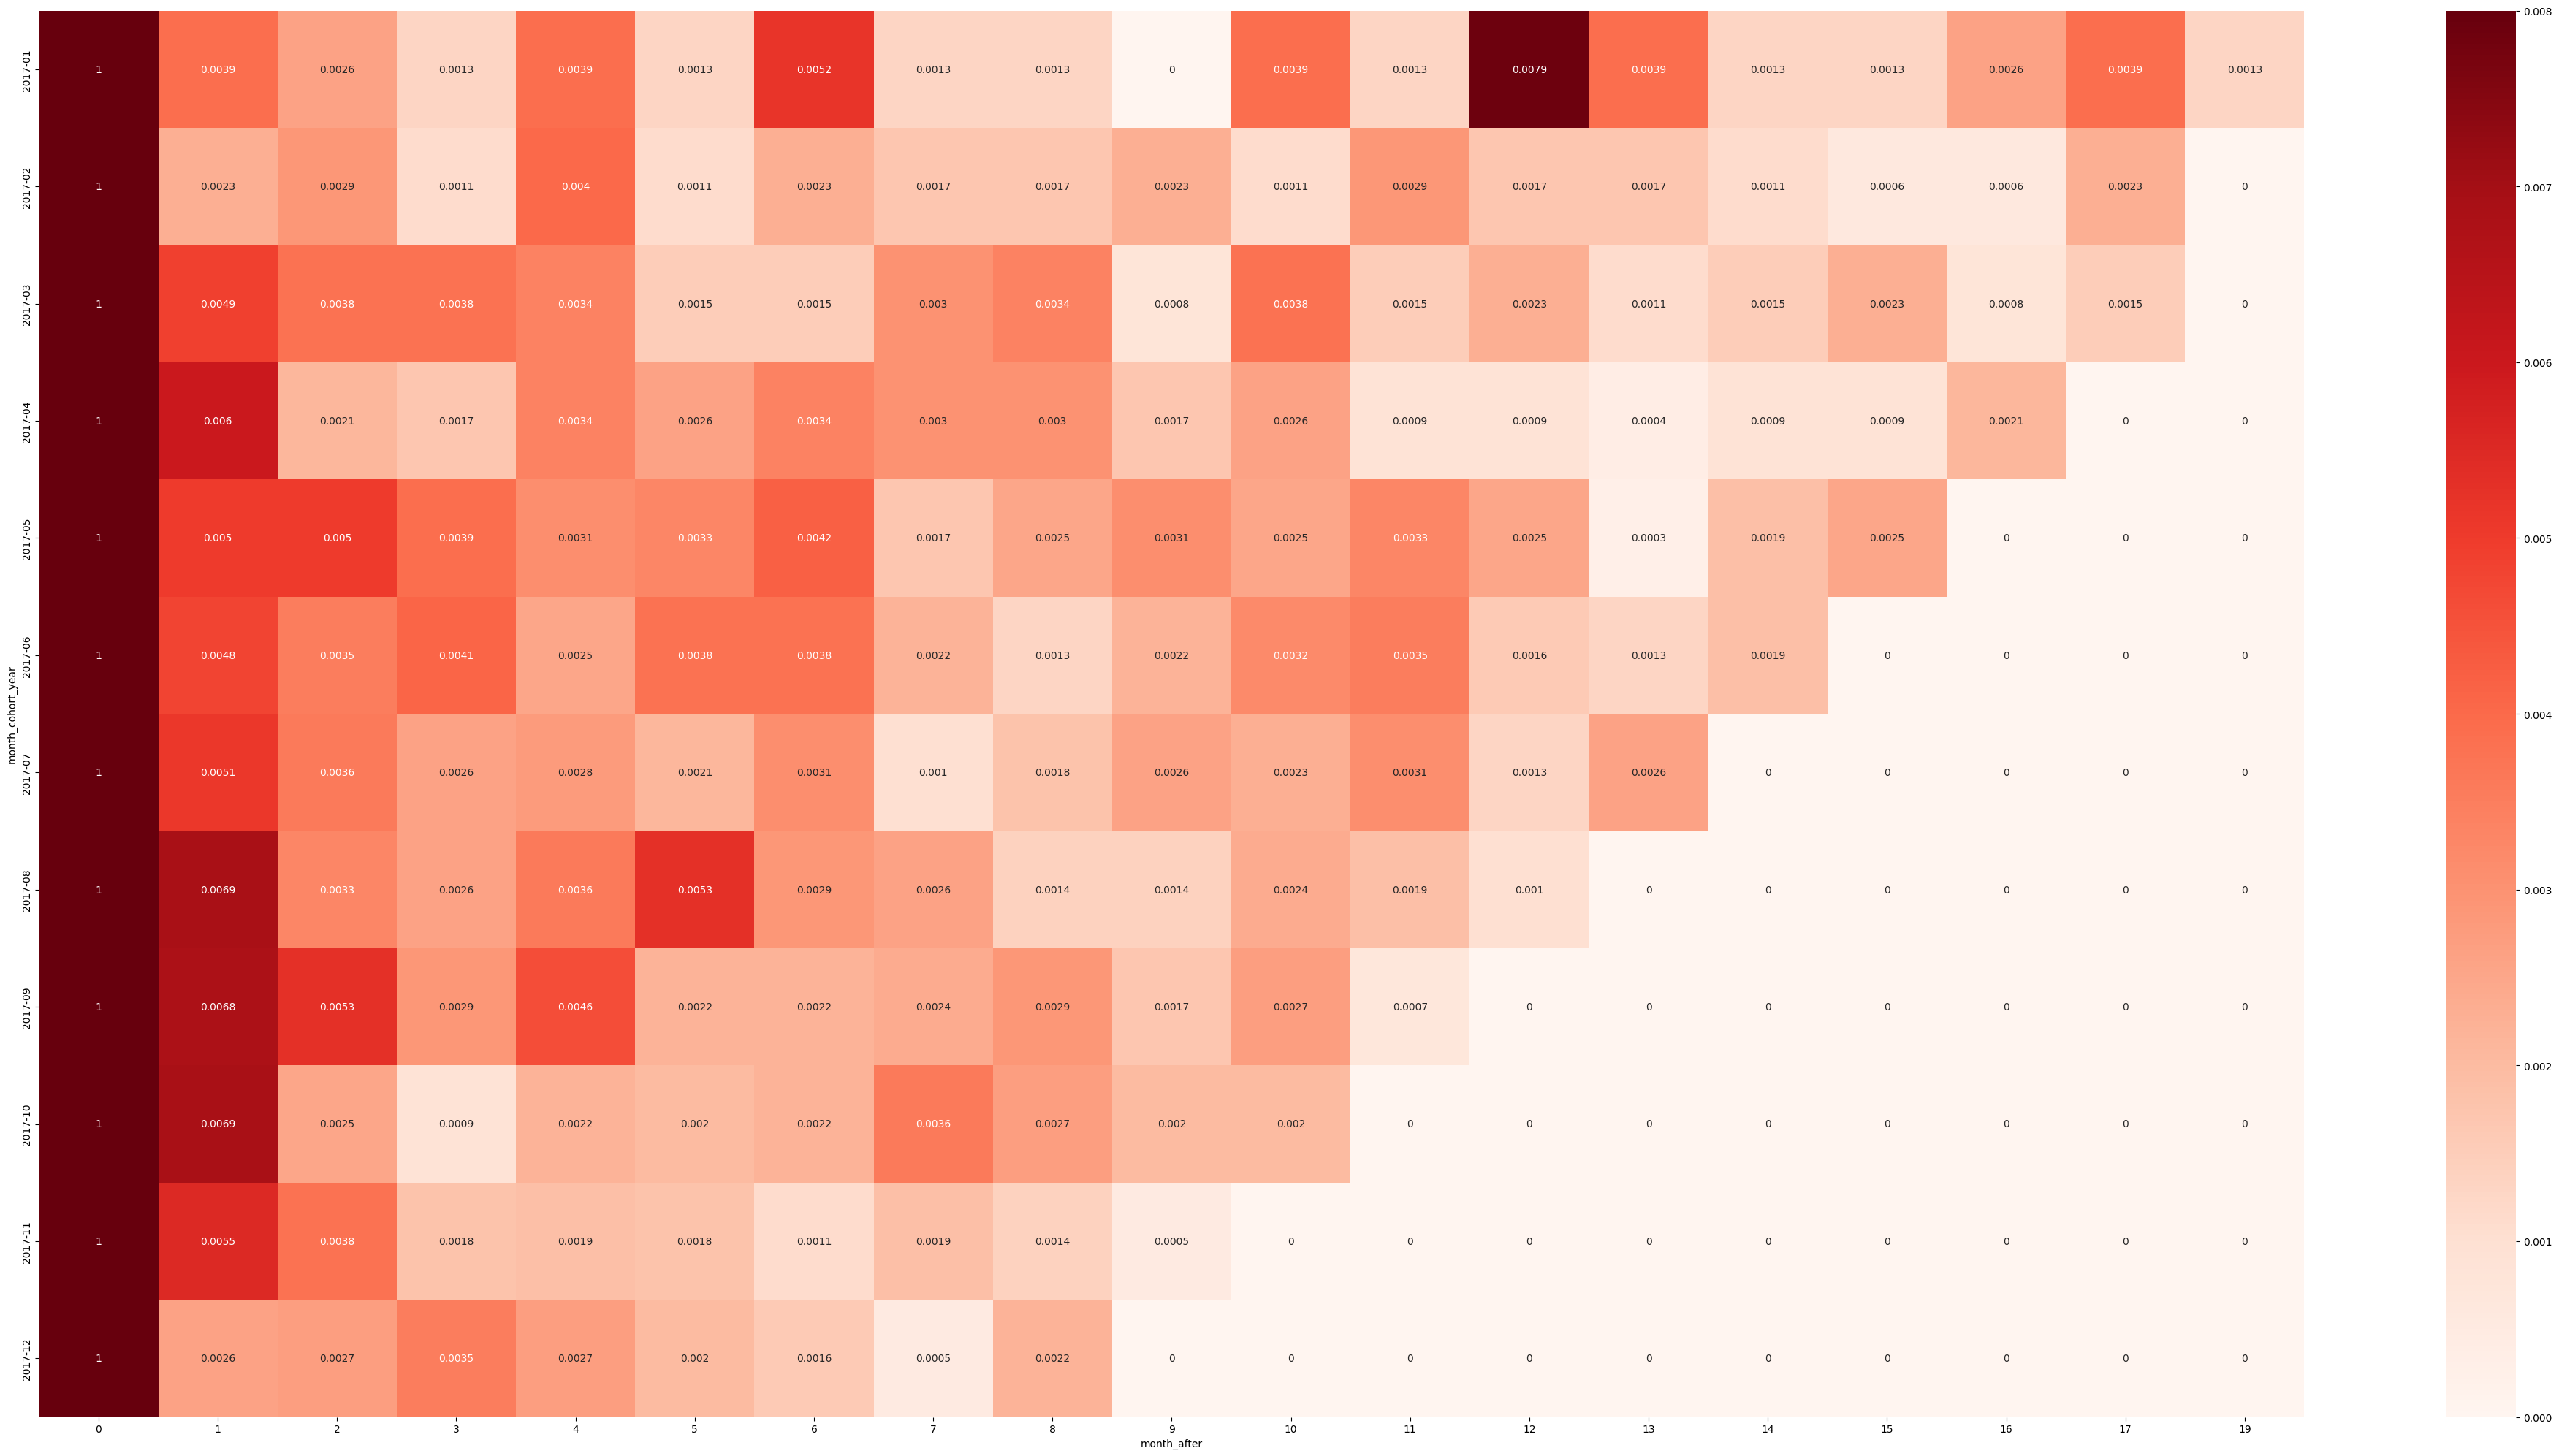

In [106]:
# Graph
# Initialize the figure
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(50, 25))
# Creating the heatmap
sns.heatmap(cohorts, annot = True,vmin = 0.0, vmax = 0.008,cmap="Reds") 

In [107]:
customer_orders_items = customer_orders.merge(olist_order_items_dataset, how='left', on='order_id')

In [174]:
co = customer_orders_items.groupby('customer_unique_id') \
                            .agg({'order_purchase_timestamp': 'max', 'order_id': 'nunique', 'price': 'sum'}) \
                            .rename(columns={'order_purchase_timestamp': 'Recency', 'order_id': 'Frequency', 'price': 'Monetary'})
co['R'] = pd.cut(co['Recency'], bins=5, labels=["1", "2", "3", "4", "5"])
co['F'] = pd.cut(co['Frequency'], bins=[0, 1, 2, 3, 4, 10], labels=["1", "2", "3", "4", "5"])
co['M'] = pd.cut(co['Monetary'], bins=[0, 100, 169, 299, 650, 15000], labels=["5", "4", "3", "2", "1"])
co['RFM'] = co['R'].astype('str') + co['F'].astype('str') + co['M'].astype('str')
co

,Recency,Frequency,Monetary,R,F,M,RFM
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,4,1,5,415
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,2,1,5,215
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,3,1,5,315
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,3,1,3,313
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,1,1570.00,2,1,1,211
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1,64.89,3,1,5,315
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,1,89.90,2,1,5,215


In [175]:
co.value_counts('RFM')

RFM
415      18987
315      14400
515      11814
215       8101
414       7091
         ...  
453          1
242          1
245          1
341          1
5nan1        1
Length: 99, dtype: int64